## Análisis Exploratorio

In [1]:
%load_ext autoreload
%autoreload 2

import sys

if "../" not in sys.path:
    sys.path.append("../")

In [2]:
import pandas as pd
from utils.db import SQLClient

sql_client = SQLClient("../../db/topoai.db")
sql_client

In [14]:
df = (
    sql_client.read("SELECT * FROM vegetation_index")
    .sort_values("date")
    .reset_index(drop=True)
)
df

,point_id,date,ndvi,ndwi,longitude,latitude
0,0,2018-01-01,0.014948,0.008800,-100.470764,25.802526
1,6663,2018-01-01,-0.001486,0.076475,-100.163979,25.639210
2,6664,2018-01-01,0.012726,0.006323,-100.477898,25.793365
3,6665,2018-01-01,-0.000598,0.041707,-100.312134,25.792776
4,6666,2018-01-01,0.006392,0.087417,-100.572845,25.835756
...,...,...,...,...,...,...
17306579,3334,2023-02-17,0.075096,-0.021911,-100.465111,25.811342
17306580,3335,2023-02-17,0.032905,-0.008263,-100.462471,25.788183
17306581,3336,2023-02-17,0.033078,-0.008965,-100.465050,25.776735
17306582,3329,2023-02-17,0.018529,-0.008352,-100.185860,25.724331


In [7]:
import matplotlib.pyplot as plt


In [9]:
import matplotlib.dates as mdates


c:\Users\avril\repos\TopoAI\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


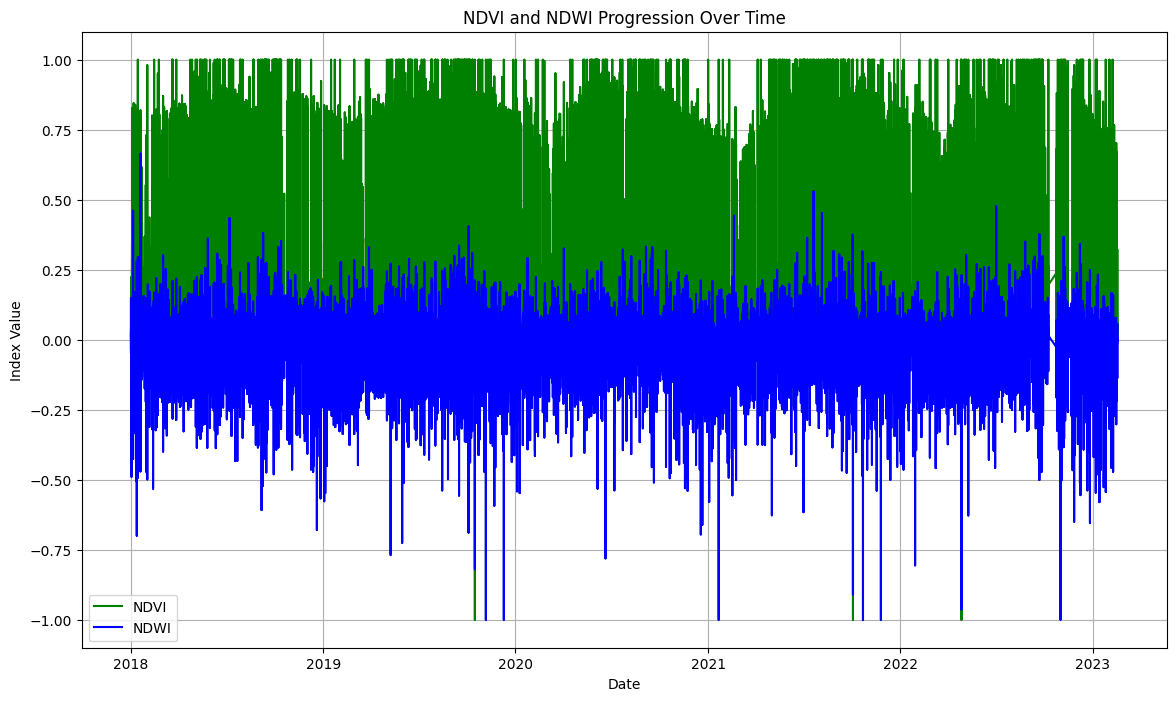

In [10]:

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(14, 8))

# Plot NDVI
plt.plot(df['date'], df['ndvi'], label='NDVI', color='green')
# Plot NDWI
plt.plot(df['date'], df['ndwi'], label='NDWI', color='blue')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('NDVI and NDWI Progression Over Time')
plt.legend()
plt.grid(True)
plt.show()

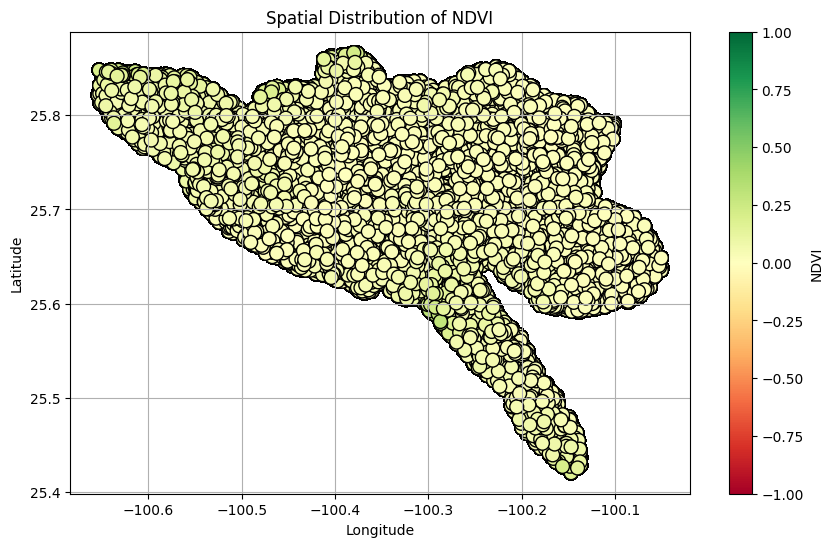

In [8]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['longitude'], df['latitude'], c=df['ndvi'], cmap='RdYlGn', edgecolor='k', s=100)
plt.colorbar(sc, label='NDVI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of NDVI')
plt.grid(True)
plt.show()

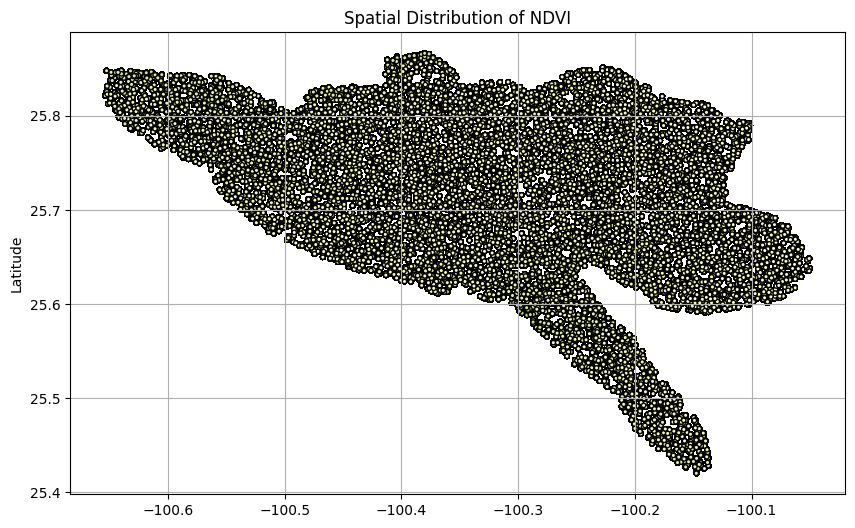

In [22]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['longitude'], df['latitude'], c=df['ndvi'], cmap='RdYlGn', edgecolor='k', s=10)
plt.ylabel('Latitude')
plt.title('Spatial Distribution of NDVI')
plt.grid(True)
plt.show()

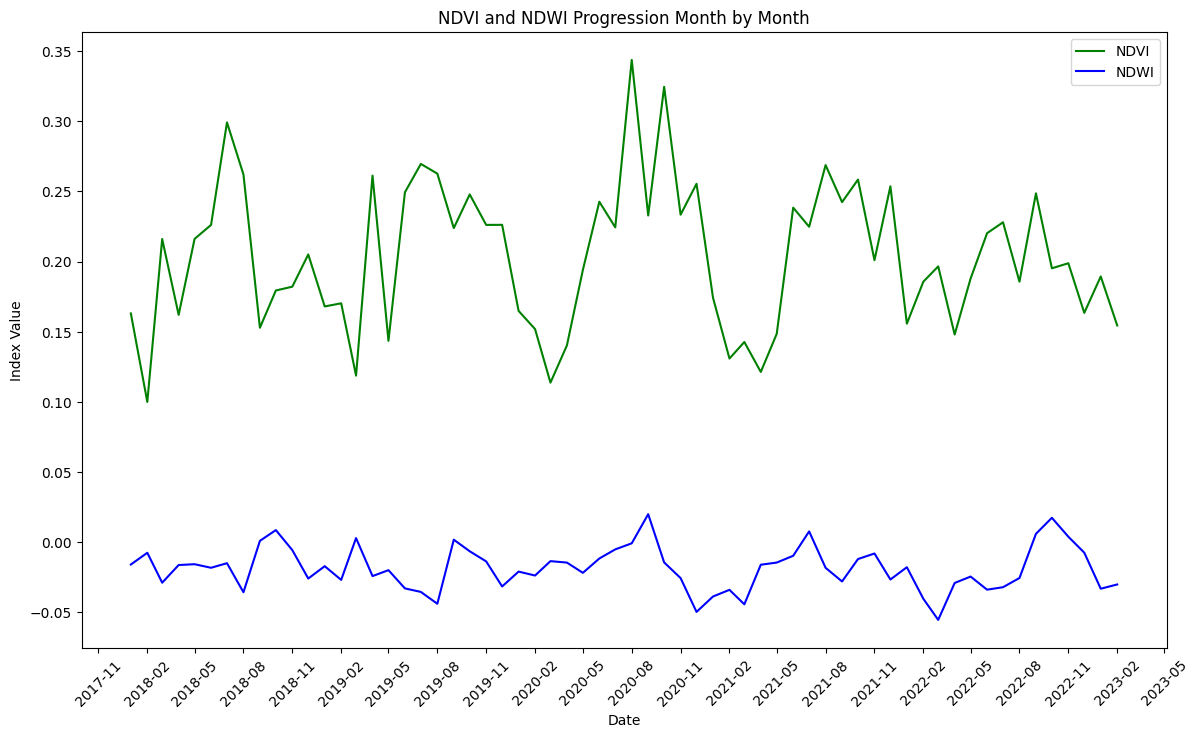

In [11]:
df['year_month'] = df['date'].dt.to_period('M')

# Aggregate mean NDVI and NDWI per month
monthly_data = df.groupby('year_month').agg({
    'ndvi': 'mean',
    'ndwi': 'mean'
}).reset_index()

monthly_data['year_month'] = monthly_data['year_month'].dt.to_timestamp()

# Plotting NDVI and NDWI by month
plt.figure(figsize=(14, 8))

# Plot NDVI
plt.plot(monthly_data['year_month'], monthly_data['ndvi'], label='NDVI', color='green')
# Plot NDWI
plt.plot(monthly_data['year_month'], monthly_data['ndwi'], label='NDWI', color='blue')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('NDVI and NDWI Progression Month by Month')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.show()


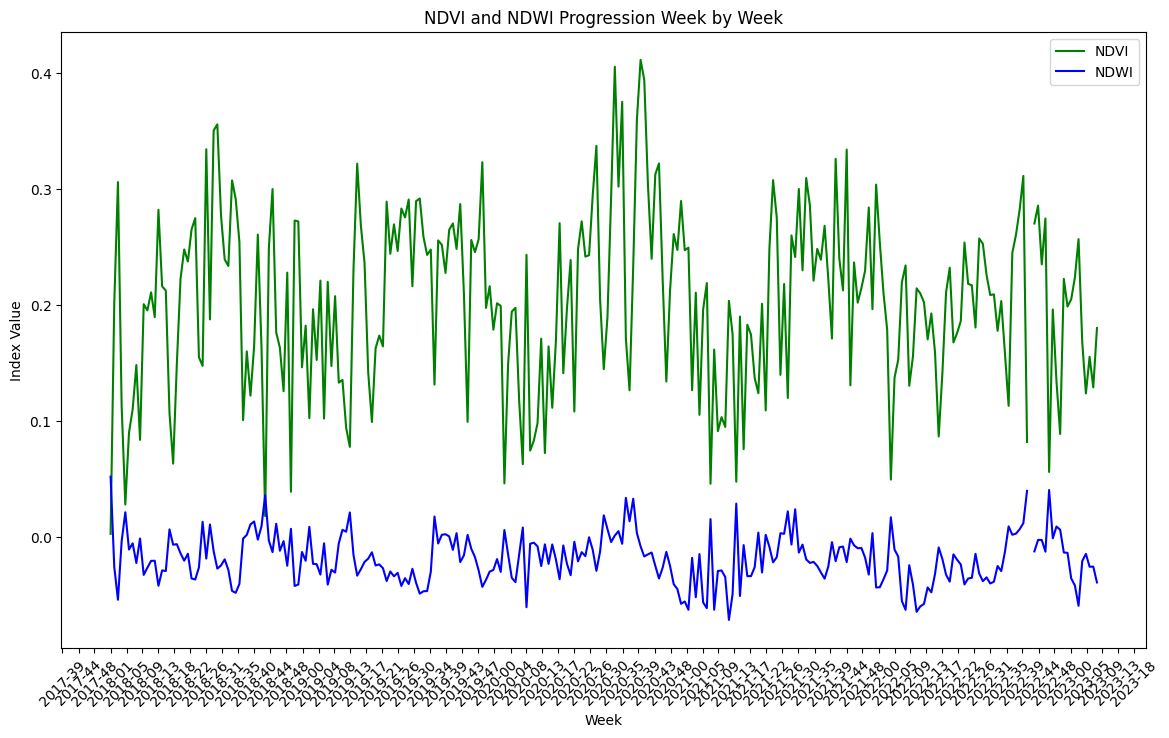

In [16]:

df['date'] = pd.to_datetime(df['date'])

# Add a column for week of the year
df['week'] = df['date'].dt.isocalendar().week

# Aggregate mean NDVI and NDWI per week
weekly_data = df.resample('W-MON', on='date').mean().reset_index()

plt.figure(figsize=(14, 8))

plt.plot(weekly_data['date'], weekly_data['ndvi'], label='NDVI', color='green')
plt.plot(weekly_data['date'], weekly_data['ndwi'], label='NDWI', color='blue')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))

plt.xlabel('Week')
plt.ylabel('Index Value')
plt.title('NDVI and NDWI Progression Week by Week')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.show()




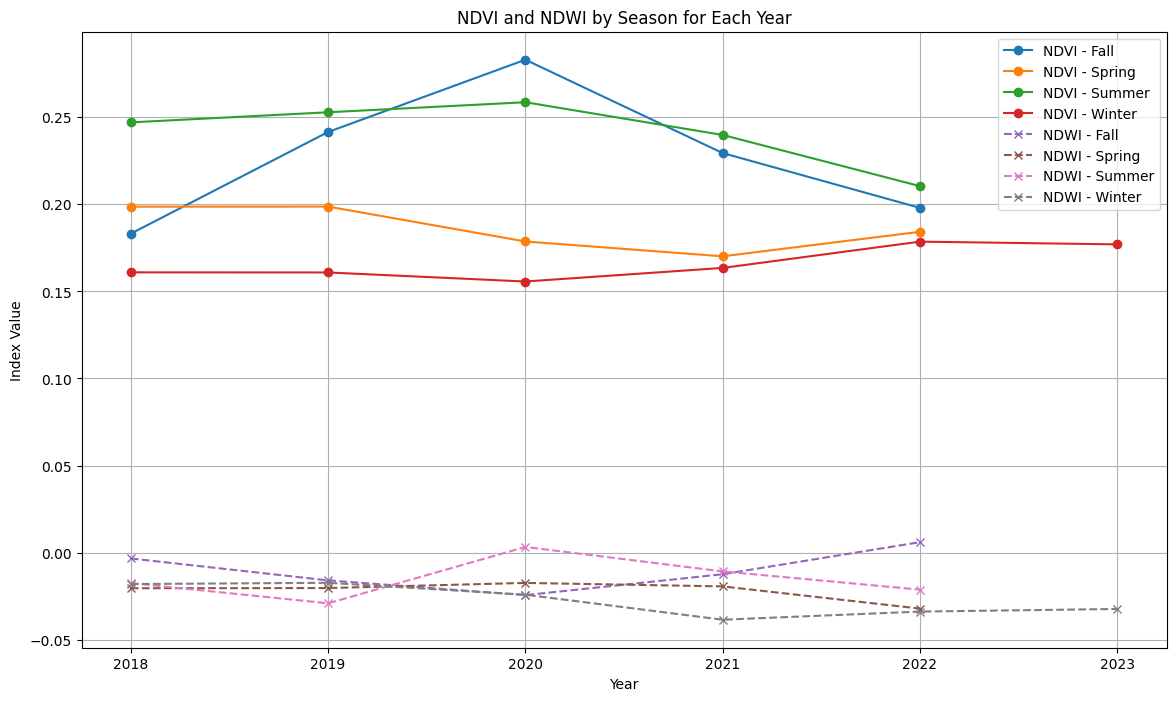

In [19]:
def get_season(date):
    Y = 2000  # dummy leap year to get the same dates for all years
    seasons = {
        'spring': (pd.Timestamp(f'{Y}-03-21'), pd.Timestamp(f'{Y}-06-20')),
        'summer': (pd.Timestamp(f'{Y}-06-21'), pd.Timestamp(f'{Y}-09-22')),
        'fall': (pd.Timestamp(f'{Y}-09-23'), pd.Timestamp(f'{Y}-12-20')),
        'winter': (pd.Timestamp(f'{Y}-12-21'), pd.Timestamp(f'{Y+1}-03-20'))
    }
    for season, (start, end) in seasons.items():
        if start <= date.replace(year=Y) <= end:
            return season
    return 'winter'

# Add season column
df['season'] = df['date'].apply(get_season)
df['year'] = df['date'].dt.year

# Aggregate mean NDVI and NDWI per season per year
seasonal_yearly_data = df.groupby(['year', 'season']).agg({
    'ndvi': 'mean',
    'ndwi': 'mean'
}).reset_index()

# Pivot to make the plot easier (seasons as columns)
seasonal_pivot = seasonal_yearly_data.pivot(index='year', columns='season', values=['ndvi', 'ndwi'])

# Plotting NDVI and NDWI by season for each year
plt.figure(figsize=(14, 8))

# Plot NDVI by season
for season in seasonal_pivot['ndvi'].columns:
    plt.plot(seasonal_pivot.index, seasonal_pivot['ndvi'][season], marker='o', linestyle='-', label=f'NDVI - {season.capitalize()}')

# Plot NDWI by season
for season in seasonal_pivot['ndwi'].columns:
    plt.plot(seasonal_pivot.index, seasonal_pivot['ndwi'][season], marker='x', linestyle='--', label=f'NDWI - {season.capitalize()}')

plt.xlabel('Year')
plt.ylabel('Index Value')
plt.title('NDVI and NDWI by Season for Each Year')
plt.legend()
plt.grid(True)
plt.show()


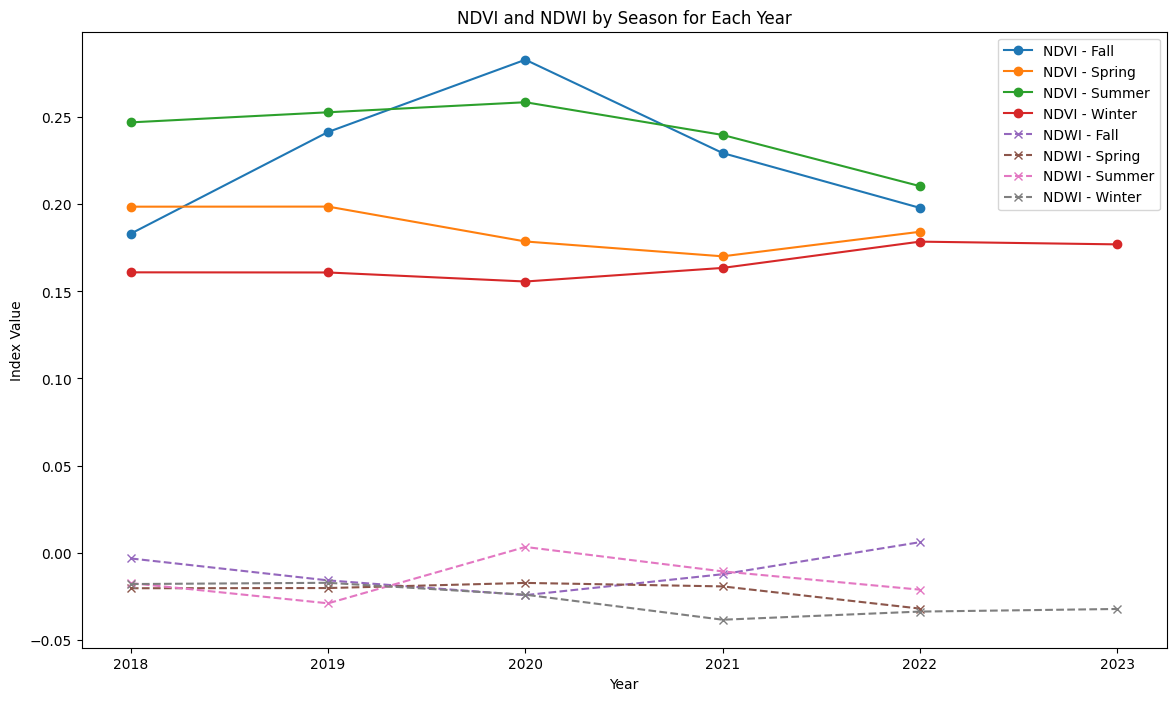

In [21]:

# Plotting NDVI and NDWI by season for each year
plt.figure(figsize=(14, 8))

# Plot NDVI by season
for season in seasonal_pivot['ndvi'].columns:
    plt.plot(seasonal_pivot.index, seasonal_pivot['ndvi'][season], marker='o', linestyle='-', label=f'NDVI - {season.capitalize()}')

# Plot NDWI by season
for season in seasonal_pivot['ndwi'].columns:
    plt.plot(seasonal_pivot.index, seasonal_pivot['ndwi'][season], marker='x', linestyle='--', label=f'NDWI - {season.capitalize()}')

plt.xlabel('Year')
plt.ylabel('Index Value')
plt.title('NDVI and NDWI by Season for Each Year')
plt.legend()
plt.grid(False)
plt.show()